In [104]:
import matplotlib.pyplot as plt
import numpy as np
import random
import skimage
import cv2
import os
import shutil
import glob
from tqdm import tqdm
import tensorflow as tf
from subprocess import check_output


seed = 17
np.random.seed = seed
random.seed = seed

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256,256,3
%matplotlib inline

# Get some data for augmentation
#### data from https://www.kaggle.com/c/data-science-bowl-2018

In [ ]:
image_ids = check_output(["ls", "dataset/stage1_train/"]).decode("utf8").split()

In [66]:
img_paths = [glob.glob('dataset/stage1_train/{}/masks/*.png'.format(id)) for id in image_ids]

## Augmentation functions

In [ ]:
def transform_img(img, angle):
    M = cv2.getRotationMatrix2D((IMG_HEIGHT/2,IMG_HEIGHT/2),angle,1)
    transformed_img = cv2.warpAffine(np.uint8(img),M,(IMG_HEIGHT,IMG_WIDTH))
    return transformed_img

def transform_concat(train, labels, angle):
    list_aug_X = []
    list_aug_Y = []
    

    for i,img in tqdm(enumerate(train), total=train.shape[0]):
        list_aug_X.append(transform_img(img, angle))
        
    for i,img in tqdm(enumerate(labels), total=train.shape[0]):
        list_aug_Y.append(transform_img(img, angle))
    
    transformed_X = np.array(list_aug_X)
    transformed_Y = np.expand_dims(np.array(list_aug_Y), axis=3)
    
#     X = np.concatenate((train, transformed_X), axis=0)
#     Y = np.concatenate((labels, transformed_Y), axis=0)
    
    return transformed_X,transformed_Y

def flip_images(X_imgs):
    X_flip = []
    channels = X_imgs.shape[3]
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMG_HEIGHT, IMG_HEIGHT, channels))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i,img_data in tqdm(enumerate(X_imgs), total=X_imgs.shape[0]):
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img_data})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

## Making the augmentations and concatenate with generic dataset

In [ ]:
X_train, Y_train, X_test = rf.get_data()

In [129]:
print('Flipping')
X_flip = flip_images(X_train)
Y_flip = flip_images(Y_train)
print('Rotate 90')
X_tr, Y_tr = transform_concat(X_train, Y_train, 90)
print('Rotate 180')
X_tr_180, Y_tr_180 = transform_concat(X_train, Y_train, 180)
print('Rotate 270')
X_tr_270, Y_tr_270 = transform_concat(X_train, Y_train, 270)

Flipping


  7%|▋         | 46/670 [00:00<00:01, 454.12it/s]

Rotate 90


 18%|█▊        | 123/670 [00:00<00:00, 1223.37it/s]

Rotate 180


 17%|█▋        | 117/670 [00:00<00:00, 1167.77it/s]

Rotate 270


100%|██████████| 670/670 [00:00<00:00, 1830.60it/s]


In [130]:
%%time
print('1')
rotated_X = np.concatenate((X_tr, X_tr_180, X_tr_270), axis=0)
print('1')
rotated_Y = np.concatenate((Y_tr, Y_tr_180, Y_tr_270), axis=0)
print('1')
X_auged = np.concatenate((rotated_X, X_flip), axis=0)
print('1')
Y_auged = np.concatenate((rotated_Y, Y_flip), axis=0)
print('1')
X = np.concatenate((X_train, X_auged), axis=0)
print('1')
Y = np.concatenate((Y_train, Y_auged), axis=0)

1
1
1
1
1
1
CPU times: user 7.68 s, sys: 24.3 s, total: 32 s
Wall time: 1min 12s


In [158]:
def data_aug(X_train, Y_train):
    print('Data augmentation')
    print('Flipping')
    X_flip = flip_images(X_train)
    Y_flip = flip_images(Y_train)
    print('Rotate 90')
    X_tr, Y_tr = transform_concat(X_train, Y_train, 90)
    print('Rotate 180')
    X_tr_180, Y_tr_180 = transform_concat(X_train, Y_train, 180)
    print('Rotate 270')
    X_tr_270, Y_tr_270 = transform_concat(X_train, Y_train, 270)
    print('Done data aug!')
    
    print('Concatenating the arrays:')
    rotated_X = np.concatenate((X_tr, X_tr_180, X_tr_270), axis=0)
    print('1')
    rotated_Y = np.concatenate((Y_tr, Y_tr_180, Y_tr_270), axis=0)
    print('1')
    X_auged = np.concatenate((rotated_X, X_flip), axis=0)
    print('1')
    Y_auged = np.concatenate((rotated_Y, Y_flip), axis=0)
    print('1')
    X = np.concatenate((X_train, X_auged), axis=0)
    print('1')
    Y = np.concatenate((Y_train, Y_auged), axis=0)
    print('Done with concatenating!')
    print('Shuffling the arrays')
    X_shuffled, Y_shuffled = unison_shuffled_copies(X, Y)
    return X_shuffled, Y_shuffled

In [131]:
X.shape, Y.shape

((4690, 256, 256, 3), (4690, 256, 256, 1))

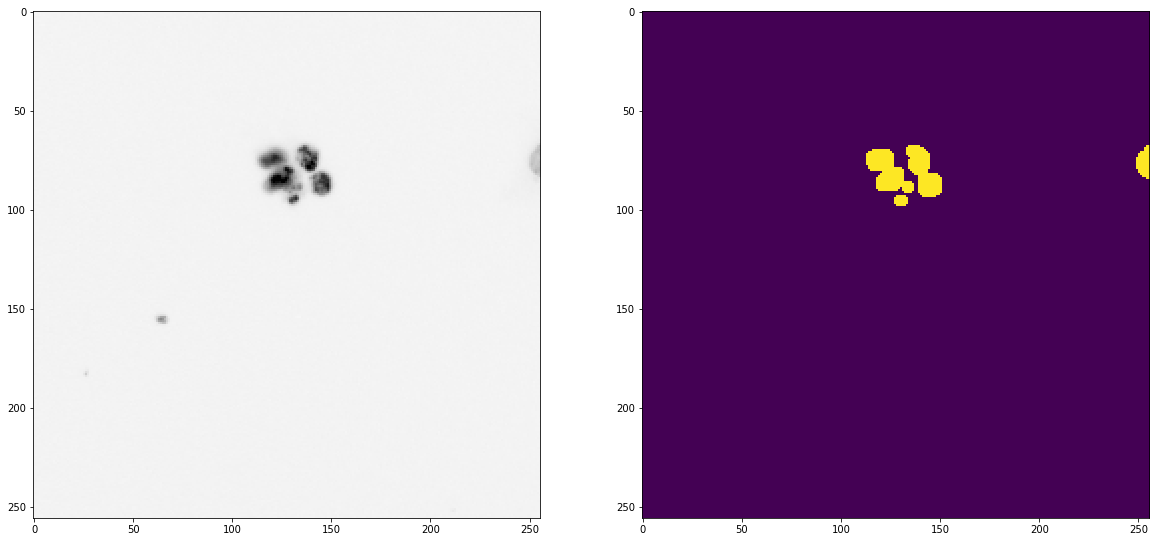

In [132]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(121)
plt.imshow(X[3])
plt.subplot(122)
plt.imshow(Y[3][:,:,0])

(<matplotlib.image.AxesImage at 0x134154d68>,
 <matplotlib.text.Text at 0x134194d30>)

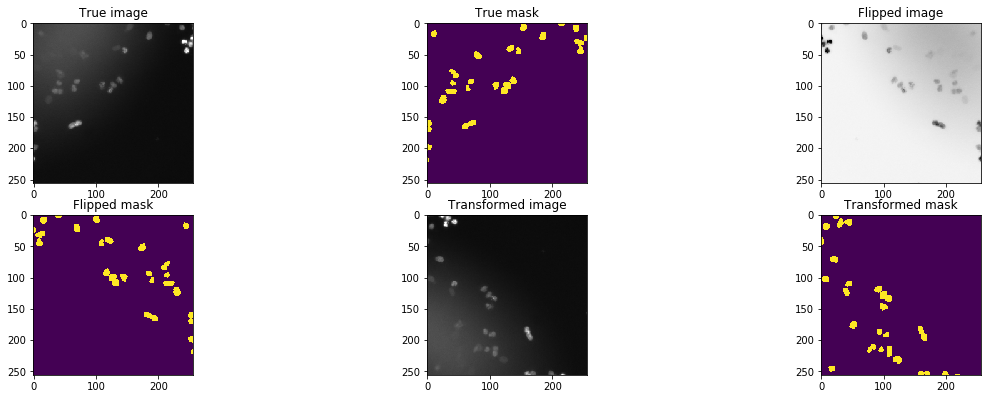

In [110]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(3,3,1)
plt.imshow(X_train[1]), plt.title('True image')
plt.subplot(3,3,2)
plt.imshow(Y_train[1][:,:,0]), plt.title('True mask')
plt.subplot(3,3,3)
plt.imshow(X_flip[3]), plt.title('Flipped image')
plt.subplot(3,3,4)
plt.imshow(Y_flip[3][:,:,0]), plt.title('Flipped mask')

plt.subplot(3,3,5)
plt.imshow(X_tr[1]), plt.title('Transformed image')
plt.subplot(3,3,6)
plt.imshow(Y_tr[1][:,:,0]), plt.title('Transformed mask')

### Shuffle the dataset

In [153]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
X_copy = np.copy(X)
Y_copy = np.copy(Y)
X_shuffled, Y_shuffled = unison_shuffled_copies(X_copy, Y_copy)

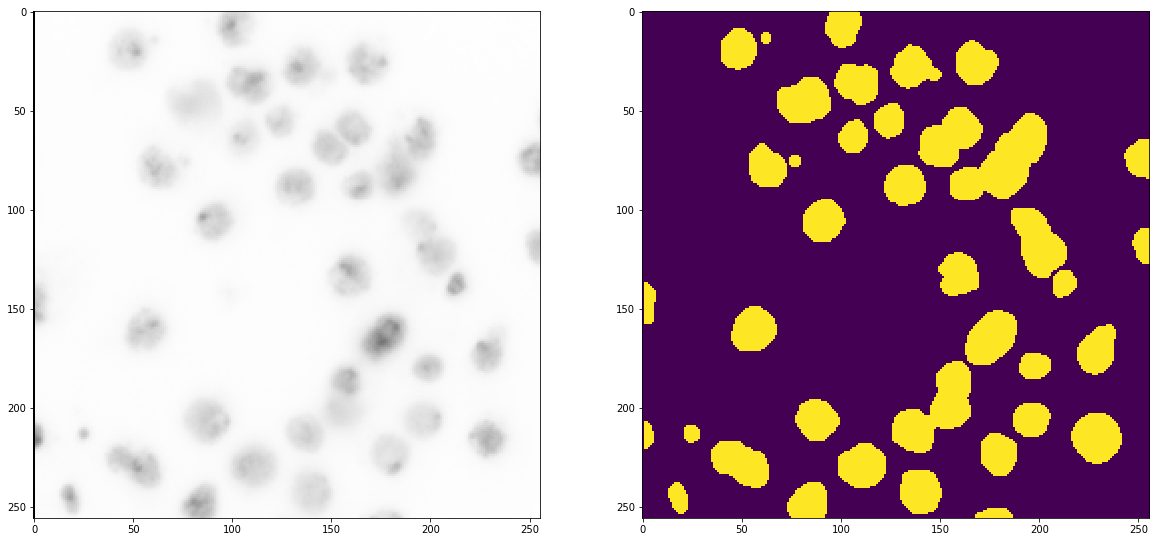

In [155]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(121)
plt.imshow(X_shuffled[3])
plt.subplot(122)
plt.imshow(Y_shuffled[3][:,:,0])

## Saving the augmented images

In [121]:
# deleting the directory with augmented images
def clean_data_augmentation(image_ids):
    if os.path.exists("images/stage1_train/"):
        shutil.rmtree("images/stage1_train/")
clean_data_augmentation(image_ids)

In [47]:
def read_img_transform(img_id, angle):
    img = cv2.imread('dataset/stage1_train/{}/images/{}.png'.format(img_id, img_id))
    res = cv2.resize(img,(IMG_HEIGHT, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
    img = transform_img(res, angle)
    return img

In [83]:
def read_mask(img_masks, angle):
    masks = skimage.io.imread_collection(img_masks)
    masks = masks.concatenate()
    mask = np.max(masks, axis=0)
    mask = skimage.transform.resize(mask, output_shape=(IMG_HEIGHT,IMG_WIDTH)+(1,), preserve_range=True, mode='constant')
    img = transform_img(mask, angle)
    return img

In [94]:
def data_aug(images_ids):
    print('Saving the train images')
    for i, image_id in tqdm(enumerate(images_ids), total=len(image_ids)):
        image = read_img_transform(image_id, 90)
        if not os.path.exists("images/stage1_train/{}/augs/".format(image_id)):
            os.makedirs("images/stage1_train/{}/augs/".format(image_id))
        cv2.imwrite("images/stage1_train/{}/augs/{}.png".format(image_id, image_id), image)
        
    print('Done')


In [91]:
def masks_aug(images_ids, ids):
    print('Saving the masks')
    for i, image_id in tqdm(enumerate(images_ids), total=len(image_ids)):
        mask = read_mask(image_id, 90)
        if not os.path.exists("images/stage1_train/{}/augs_masks/".format(ids[i])):
            os.makedirs("images/stage1_train/{}/augs_masks/".format(ids[i]))
        cv2.imwrite("images/stage1_train/{}/augs_masks/{}.png".format(ids[i], ids[i]), mask)

    print('Done')